#### Amazon Datasets Selection: Categories And Size
Generally, our project is based on the [Amazon Review Dataset](http://jmcauley.ucsd.edu/data/amazon/) . The dataset consists of product reviews and metadata from Amazon, including 142.8 million reviews spanning May 1996 - July 2014. 
We divide the whole data according to categories. We view these categories as two major types: **content-based product** and **brand-based product**.
- Content-based product: this refers to products like books, movies and TV, video games, etc. In this subcategory of product, people are more interested in the content of the product,. The brand itself, if any, does not matter much to the customer.
- Brand-based product: this refers to products like clothes, home appliances, etc. Customers attitudes towards such products have something to do with the brands, e.g., some customers might be loyal to certain brands.

We would like to experiment with the typical data of these two subcategories. Our project so far is based on the following data (both reviews and the product metadata):
- Movies and TV (content-based)
	- In addition, we make use of [IMDB ratings](https://datasets.imdbws.com/) to give us a relative objective rating for movies and TV.
		- IMDB is an online database of information related to films, television programs, home videos and video games, and internet streams, including cast, production crew and personnel biographies, plot summaries, trivia, and fan reviews and ratings.
		- We find that usually content-based product has a very good feature: most of them have other rating database. These ratings are created by those truly love movies or books. Their ratings are more objective than a commercial website. But there also exist bias on those datasets. But in our assumption, we consider these bias much smaller than Amazon data.
		- Based on above assumption, then we can use those relatively objective database to verify the validity of our approach to detect fake reviews, at least biased reviews. The concept of this test is: if we remove those fake reviews (detected by our analysis). The rating distribution of Amazon movies should be similar like IMDB data.
- Clothing, Shoes and Jewellery (brand-based)
- Home and Kitchen (brand based)


In our research, those products and users that have only few reviews can not help us to find out the regulation of fake reviews therefore we only chose the dataset in which each of the reviewers and products have at least 5 reviews, called 5-core dataset.



### Data Loading Phase

In [3]:
import pandas as pd
import gzip
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set(color_codes=True)

In [4]:
# define a function to load the data
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

#### We have first converted the file into csv format.

In [8]:
# use the function above to load the data and saved as csv files that we can directly use

# Home and Kitchen
home_reviews = pd.read_csv('./home_reviews.csv')
home_meta = pd.read_csv('./home_meta.csv')

# Clothing_Shoes_and_Jewelry
clothing_reviews = pd.read_csv('./clothing_reviews.csv')
clothing_meta = pd.read_csv('./clothing_meta.csv')

# Movies and TV
movies_review = pd.read_csv('./movies_reviews.csv')
movies_meta =  pd.read_csv('./movies_meta.csv')

In [203]:
# read the authoritative datasets for further use: IMDB dataset
IMDB_ratings = pd.read_csv('./title.ratings.tsv', sep='\t', header=0)
IMDB_basics = pd.read_csv('./title.basics.tsv', sep='\t', header=0, usecols=[0, 1, 2, 3, 8])

In [204]:
# observation of the IMDB data
IMDB_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.8,1439
1,tt0000002,6.3,172
2,tt0000003,6.6,1041
3,tt0000004,6.4,102
4,tt0000005,6.2,1735


In [205]:
IMDB_basics.head()

,tconst,titleType,primaryTitle,originalTitle,genres
0,tt0000001,short,Carmencita,Carmencita,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,"Comedy,Short"


In [206]:
# combine the two dataset into one IMDB dataset
IMDB_data = IMDB_ratings.merge(IMDB_basics, left_on='tconst', right_on='tconst')

In [207]:
IMDB_data.head()

,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,genres
0,tt0000001,5.8,1439,short,Carmencita,Carmencita,"Documentary,Short"
1,tt0000002,6.3,172,short,Le clown et ses chiens,Le clown et ses chiens,"Animation,Short"
2,tt0000003,6.6,1041,short,Pauvre Pierrot,Pauvre Pierrot,"Animation,Comedy,Romance"
3,tt0000004,6.4,102,short,Un bon bock,Un bon bock,"Animation,Short"
4,tt0000005,6.2,1735,short,Blacksmith Scene,Blacksmith Scene,"Comedy,Short"


In [208]:
# search for missing values
IMDB_data.isnull().any()

tconst           False
averageRating    False
numVotes         False
titleType        False
primaryTitle     False
originalTitle    False
genres           False
dtype: bool

<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Reasons why we separate two subcategories.</b><br>
</font>
<font color='black'>
First, the reviewers for content-based data like movies are more concerned with the content itself, which has little to do with the brand.
    Second, in such content-based data, brand information is likely to be NaN. Brand information is informative, and we need other techniques to handle content-based data.<br>
    
</font>
</div>

### Data Initial Observation

In reviews data:
- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review, e.g. 2/3
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)

In [10]:
# Data Initial Observation
home_reviews.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,"10 19, 2013"
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,zoku,1403049600,"06 18, 2014"
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,"05 5, 2013"
3,A2MHCTX43MIMDZ,0615391206,"M. Johnson ""Tea Lover""","[14, 18]",This book is a must have if you get a Zoku (wh...,5.0,Creative Combos,1312416000,"08 4, 2011"
4,AHAI85T5C2DH3,0615391206,PugLover,"[0, 0]",This cookbook is great. I have really enjoyed...,4.0,A must own if you own the Zoku maker...,1402099200,"06 7, 2014"


In metadata:
- asin - ID of the product, e.g. 0000031852
- title - name of the product
- price - price in US dollars (at time of crawl)
- imUrl - url of the product image
- related - related products (also bought, also viewed, bought together, buy after viewing)
- salesRank - sales rank information
- brand - brand name
- categories - list of categories the product belongs to

In [11]:
home_meta.head(5)

,asin,salesRank,imUrl,categories,title,description,related,price,brand
0,0076144011,{'Books': 6285595},http://g-ecx.images-amazon.com/images/G/01/x-s...,[['Home & Kitchen']],"Ninjas, Piranhas, and Galileo",NaN,NaN,NaN,NaN
1,0130350591,{'Kitchen & Dining': 459680},http://ecx.images-amazon.com/images/I/21zcx6RC...,"[['Home & Kitchen', 'Kitchen & Dining', 'Dinin...",Le Creuset Kiwi (Green) Butter Dish Stoneware,Each piece of Le Creuset dinnerware is crafted...,NaN,NaN,NaN
2,0307394530,"{'Arts, Crafts & Sewing': 3597}",http://ecx.images-amazon.com/images/I/51A4FWuj...,"[['Home & Kitchen', 'Artwork', 'Posters & Prin...",Martha Stewart's Wedding Cakes,Of all the decisions that go into planning a w...,"{'also_bought': ['144630163X', '1402717733', '...",14.99,Random House
3,0439903491,{'Software': 7065},http://ecx.images-amazon.com/images/I/61tVxcko...,"[['Home & Kitchen', 'Artwork', 'Posters & Prin...",NaN,Shiver me timbers! Solve I SPY pirate picture ...,"{'also_viewed': ['B000YFSZU8', 'B0016KWZB0', '...",29.99,NaN
4,0578060604,NaN,http://ecx.images-amazon.com/images/I/41aCELWJ...,"[['Home & Kitchen', 'Furniture', 'Kitchen & Di...",Build A Maloof Inspired Low Back Dining Chair ...,The Maloofinspired Low Back Dining Chair is no...,{'also_viewed': ['B004IO6RS8']},NaN,NaN


In [13]:
clothing_reviews.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,1394841600,"03 15, 2014"


In [178]:
clothing_meta.head(5)

,asin,related,title,price,salesRank,imUrl,brand,categories,description
0,0000037214,"{'also_viewed': ['B00JO8II76', 'B00DGN4R1Q', '...",Purple Sequin Tiny Dancer Tutu Ballet Dance Fa...,6.99,{'Clothing': 1233557},http://ecx.images-amazon.com/images/I/31mCncNu...,Big Dreams,"[['Clothing, Shoes & Jewelry', 'Girls'], ['Clo...",NaN
1,0000031887,"{'also_bought': ['0000031852', '0000031895', '...",Ballet Dress-Up Fairy Tutu,6.79,{'Sports &amp; Outdoors': 8547},http://ecx.images-amazon.com/images/I/314qZjYe...,Boutique Cutie,"[['Clothing, Shoes & Jewelry', 'Girls', 'Cloth...",This adorable basic ballerina tutu is perfect ...
2,0123456479,"{'also_bought': ['B000BMTCK6', 'B0006JCGUM', '...",SHINING IMAGE HUGE PINK LEATHER JEWELRY BOX / ...,64.98,{'Kitchen & Dining': 16987},http://ecx.images-amazon.com/images/I/413tGhqo...,NaN,"[['Clothing, Shoes & Jewelry', 'Novelty, Costu...",Elegance par excellence. Hand-crafted of the f...
3,0456844570,"{'also_viewed': ['B008MTRT1O', 'B00BUG47S4', '...",RiZ Women's Beautify Crafted &frac12; Rimmed F...,NaN,{'Clothing': 1180499},http://ecx.images-amazon.com/images/I/31QZTHxv...,NaN,"[['Clothing, Shoes & Jewelry', 'Women', 'Acces...",NaN
4,0456808574,"{'also_viewed': ['B00A6JD8EA', 'B00BFL4FTA', '...",Lantin White Visor Wrap Around Ski Style Aviat...,NaN,{'Clothing': 1038084},http://ecx.images-amazon.com/images/I/31UsrgT5...,NaN,"[['Clothing, Shoes & Jewelry', 'Women', 'Acces...",NaN


In [15]:
movies_review.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ADZPIG9QOCDG5,0005019281,"Alice L. Larson ""alice-loves-books""","[0, 0]",This is a charming version of the classic Dick...,4.0,good version of a classic,1203984000,"02 26, 2008"
1,A35947ZP82G7JH,0005019281,Amarah Strack,"[0, 0]",It was good but not as emotionally moving as t...,3.0,Good but not as moving,1388361600,"12 30, 2013"
2,A3UORV8A9D5L2E,0005019281,Amazon Customer,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3.0,Winkler's Performance was ok at best!,1388361600,"12 30, 2013"
3,A1VKW06X1O2X7V,0005019281,"Amazon Customer ""Softmill""","[0, 0]",Henry Winkler is very good in this twist on th...,5.0,It's an enjoyable twist on the classic story,1202860800,"02 13, 2008"
4,A3R27T4HADWFFJ,0005019281,BABE,"[0, 0]",This is one of the best Scrooge movies out. H...,4.0,Best Scrooge yet,1387670400,"12 22, 2013"


In [16]:
movies_meta.head(5)

,asin,categories,description,title,price,salesRank,imUrl,related,brand
0,0000143561,"[['Movies & TV', 'Movies']]","3Pack DVD set - Italian Classics, Parties and ...","Everyday Italian (with Giada de Laurentiis), V...",12.99,{'Movies & TV': 376041},http://g-ecx.images-amazon.com/images/G/01/x-s...,"{'also_viewed': ['B0036FO6SI', 'B000KL8ODE', '...",NaN
1,0000589012,"[['Movies & TV', 'Movies']]",NaN,Why Don't They Just Quit? DVD Roundtable Discu...,15.95,{'Movies & TV': 1084845},http://ecx.images-amazon.com/images/I/519%2B1k...,"{'also_bought': ['B000Z3N1HQ', '0578045427', '...",NaN
2,0000695009,"[['Movies & TV', 'Movies']]",NaN,Understanding Seizures and Epilepsy DVD,NaN,{'Movies & TV': 1022732},http://g-ecx.images-amazon.com/images/G/01/x-s...,NaN,NaN
3,000107461X,"[['Movies & TV', 'Movies']]",NaN,Live in Houston [VHS],NaN,{'Movies & TV': 954116},http://ecx.images-amazon.com/images/I/41WY47gL...,NaN,NaN
4,0000143529,"[['Movies & TV', 'Movies']]",Disc 1: Flour Power (Scones; Shortcakes; South...,My Fair Pastry (Good Eats Vol. 9),19.99,{'Movies & TV': 463562},http://ecx.images-amazon.com/images/I/51QY79CD...,"{'also_bought': ['B000NR4CRM', 'B0019BK3KQ', '...",NaN


<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Observation Description</b><br>
</font>
<font color='black'>
In reviews data, there are several features that we found useful in our further study like reviewerID, asin(products ID),helpful(reviews helpfulness), overall(rate given out by reiewers), unixReviewTime,reviewTime(the time of the reviews come out). Noted that the content in 'helpful' column should be transformed into numerical values.<br>
In meta data,the features like asin,brand,title seems useful. Noted that there are some missing values in brand that need further processing in 'brand' column.<br>
    
</font>
</div>

### Search for missing values in brand column

In [174]:
# for home and kitchen products
print('The Percentage Of Number Of The NaN In Brand Column :',home_meta.brand.isna().sum()/home_meta.shape[0]* 100,'%')

The Percentage Of Number Of The NaN In Brand Column : 65.5118676027717 %


In [175]:
# for clothing_shoes_jewelry products
print('The Percentage Of Number Of The NaN In Brand Column :',clothing_meta.brand.isna().sum()/clothing_meta.shape[0]* 100,'%')

The Percentage Of Number Of The NaN In Brand Column : 93.52081703676505 %


In [176]:
# for movies and TV products
print('The Percentage Of Number Of The NaN In Brand Column :',movies_meta.brand.isna().sum()/movies_meta.shape[0]* 100,'%')

The Percentage Of Number Of The NaN In Brand Column : 94.09277029200128 %


<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Observation Description</b><br>
</font>
<font color='black'>
After caclulation of the protion of the NaN in brand column, brand-based products have lower portion of NaN compared with content-based products. That's why we utilize the brand features to find out the suspicious reviewers on brand-based products, but utilize overall features (overall rating)on content-based products.<br>
    
</font>
</div>

### Search for impossible values : Check the range of its columns values

In [180]:
# for home and kitchen products
home_reviews.describe()

,overall,unixReviewTime
count,551682.000000,5.516820e+05
mean,4.316655,1.348687e+09
std,1.110749,6.120238e+07
min,1.000000,9.572256e+08
25%,4.000000,1.331770e+09
50%,5.000000,1.367626e+09
75%,5.000000,1.388880e+09
max,5.000000,1.406074e+09


In [27]:
#for clothing products
clothing_reviews.describe()

,overall,unixReviewTime
count,278677.000000,2.786770e+05
mean,4.245133,1.374197e+09
std,1.103747,2.904510e+07
min,1.000000,1.048896e+09
25%,4.000000,1.362787e+09
50%,5.000000,1.382141e+09
75%,5.000000,1.393200e+09
max,5.000000,1.406074e+09


In [28]:
# for movies products
movies_review.describe()

,overall,unixReviewTime
count,1.697533e+06,1.697533e+06
mean,4.110648e+00,1.262422e+09
std,1.197615e+00,1.289277e+08
min,1.000000e+00,8.793792e+08
25%,4.000000e+00,1.164413e+09
50%,5.000000e+00,1.307491e+09
75%,5.000000e+00,1.373242e+09
max,5.000000e+00,1.406074e+09


<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Observation Description</b><br>
</font>
<font color='black'>
No impossible values in overall rates were found.<br>
    
</font>
</div>

### Features Extraction: extracted the useful features we mentioned above

In [29]:
# for reviews data, we extracted the features: 'reviewerID','asin','helpful','overall','unixReviewTime','reviewTime'
def useful_reviews(df):
    df_useful_reviews = df.loc[:,['reviewerID','asin','helpful','overall','unixReviewTime','reviewTime']]
    return df_useful_reviews

# for meta data, we extracted the features: 'asin','brand','title'
def useful_meta(df):
    df_useful_meta = df.loc[:,['asin','brand','title']]
    return df_useful_meta

In [31]:
# for home and kitchen products:
home_useful_reviews = useful_reviews(home_reviews)
home_useful_meta = useful_meta(home_meta)

In [32]:
# for clothing products:
clothing_useful_reviews = useful_reviews(clothing_reviews)
clothing_useful_meta = useful_meta(clothing_meta)

In [33]:
# for movies products:
movies_useful_reviews = useful_reviews(movies_review)
movies_useful_meta = useful_meta(movies_meta)

In [ ]:
# save as csv file:

# for home and kitchen products:
home_useful_reviews.to_csv('home_useful_reviews.csv',index=False,header = True)
home_useful_meta.to_csv('home_useful_meta.csv',index=False,header = True)

# for clothing products:
clothing_useful_reviews.to_csv('clothing_useful_reviews.csv',index=False,header = True)
clothing_useful_meta.to_csv('clothing_useful_meta.csv',index=False,header = True)

# for movies products:
movies_useful_reviews.to_csv('movies_useful_reviews.csv',index=False,header = True)
movies_useful_meta.to_csv('movies_useful_meta.csv',index=False,header = True)

### Data Deeper Observation

In [140]:
# Distribution of number of the reviews of the products  
def distribution_products_reviews(df):
    df_num = df.groupby('asin').count().sort_values(by='reviewerID',ascending = False)
    # display the distribution
    plt.figure(figsize=(8,5))
    ax = sns.distplot(df_num['reviewerID'],kde=False, rug=False,hist_kws={'log':True})
    ax.set_xlabel('Larger Range Of Reviews Number')
    ax.set_ylabel('Number')
    
    plt.figure(figsize=(8,5))
    df_num100 = df_num[df_num['reviewerID']<100]
    ax = sns.distplot(df_num100['reviewerID'],kde=False, rug=False,hist_kws={'log':True})
    ax.set_xlabel('Smaller Range Of Reviews Number')
    ax.set_ylabel('Number')

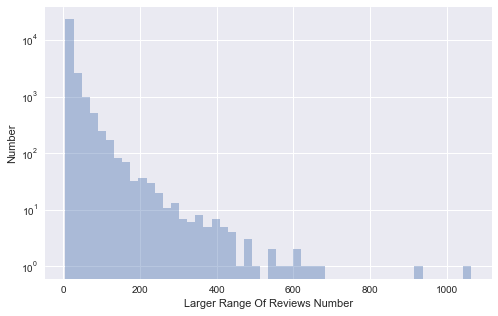

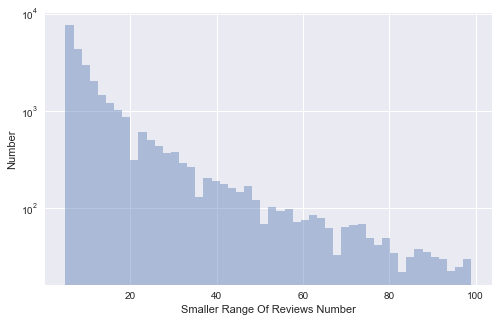

In [141]:
# for home and kitchen products
distribution_products_reviews(home_useful_reviews)

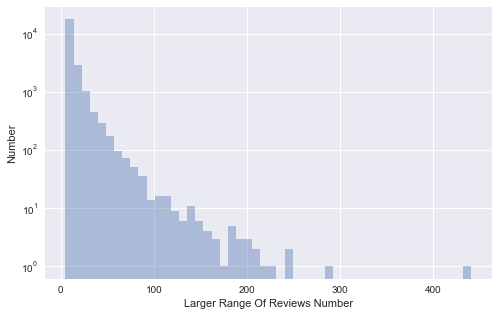

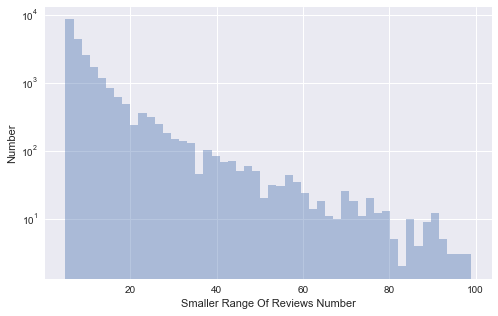

In [142]:
# for clothing products
distribution_products_reviews(clothing_useful_reviews)

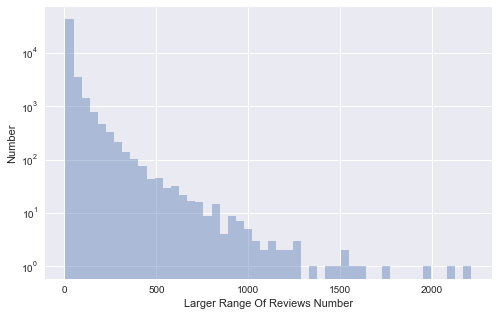

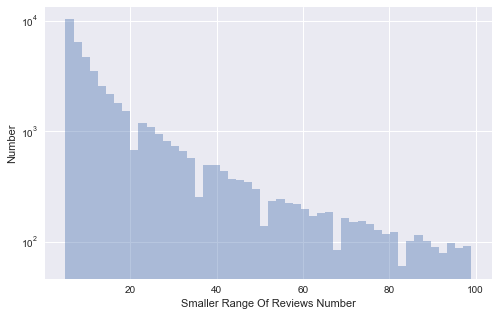

In [143]:
# for movies products
distribution_products_reviews(movies_useful_reviews)

<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Observation Description</b><br>
</font>
<font color='black'>
Among these three categories, most of the products have fewer than 20 reviews.<br>
    
</font>
</div>

In [146]:
# Distribution of number of the reviews of the users  
def distribution_users_reviews(df):
    df_num = df.groupby('reviewerID').count().sort_values(by='asin',ascending = False)
    
    # display the distribution
    plt.figure(figsize=(8,5))
    ax = sns.distplot(df_num['asin'],kde=False, rug=False,hist_kws={'log':True})
    ax.set_xlabel('Larger Range Of Reviews Number')
    ax.set_ylabel('Number')
    
    plt.figure(figsize=(8,5))
    df_num100 = df_num[df_num['asin']<100]
    ax = sns.distplot(df_num100['asin'],kde=False, rug=False,hist_kws={'log':True})
    ax.set_xlabel('Smaller Range Of Reviews Number')
    ax.set_ylabel('Number')

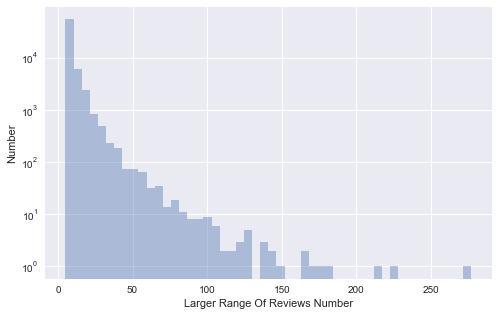

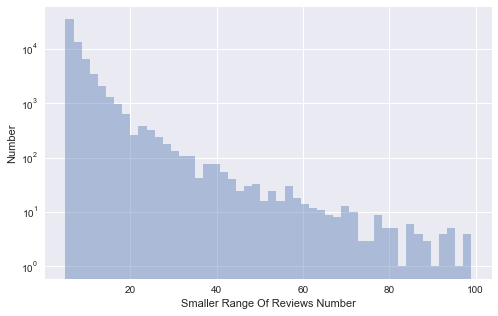

In [147]:
# for home and kitchen products
distribution_users_reviews(home_useful_reviews)

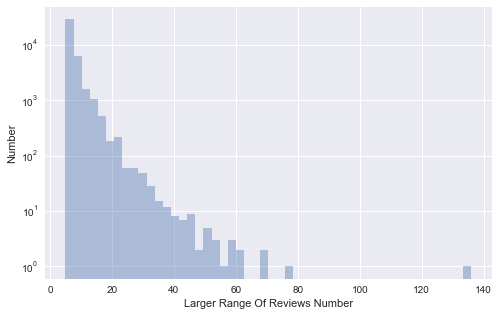

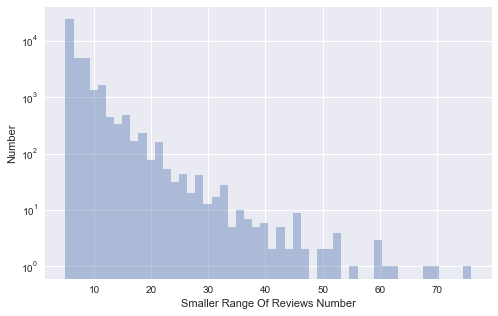

In [148]:
# for clothing products
distribution_users_reviews(clothing_useful_reviews)

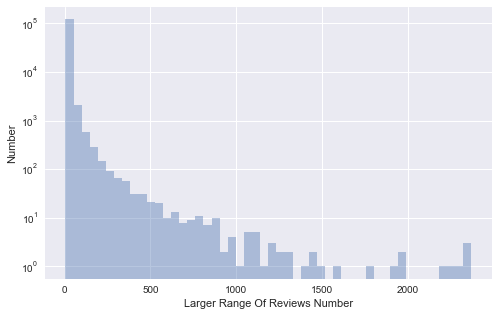

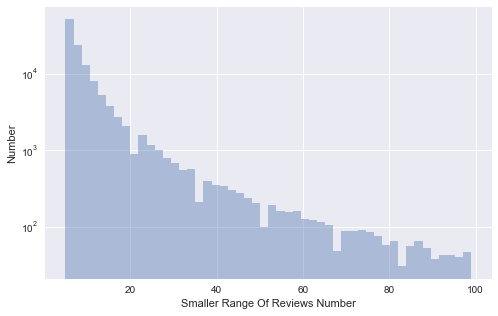

In [149]:
# for movies and TV products
distribution_users_reviews(movies_useful_reviews)

<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Observation Description</b><br>
</font>
<font color='black'>
Among these three categories, most of the users have fewer than 20 reviews.<br>
    
</font>
</div>

In [181]:
# Distribution of ratings of the item that have largest number of reviews

# for home and kitchen products
home_useful_reviews_num = home_useful_reviews.groupby('asin').count().sort_values(by='reviewerID',ascending = False)
home_useful_reviews_num.head(5)

,reviewerID,helpful,overall,unixReviewTime,reviewTime
asin,,,,,
B00006JSUA,1064,1064,1064,1064,1064
B001N07KUE,921,921,921,921,921
B00006IUWA,662,662,662,662,662
B00005B8K5,656,656,656,656,656
B000QFDNP8,634,634,634,634,634


Text(0.5,1,'The Distribution Of Reviews Of One Products')

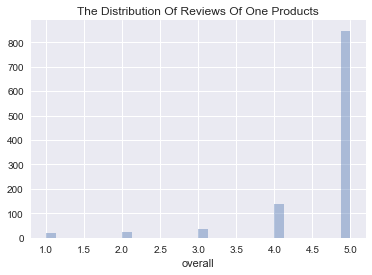

In [188]:
sns.distplot(home_useful_reviews[home_useful_reviews.asin=='B00006JSUA'].overall,kde=False, rug=False)
plt.title('The Distribution Of Reviews Of One Products')

In [185]:
# for clothing products
clothing_useful_reviews_num = clothing_useful_reviews.groupby('asin').count().sort_values(by='reviewerID',ascending = False)
clothing_useful_reviews_num.head(5)

,reviewerID,helpful,overall,unixReviewTime,reviewTime
asin,,,,,
B005LERHD8,441,441,441,441,441
B005GYGD7O,286,286,286,286,286
B008WYDP1C,249,249,249,249,249
B0058XIMMM,241,241,241,241,241
B00CKGB85I,225,225,225,225,225


Text(0.5,1,'The Distribution Of Reviews Of One Products')

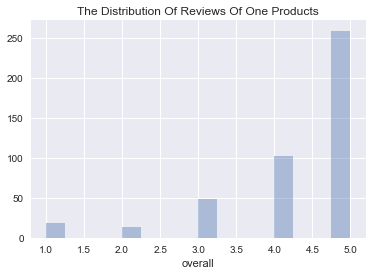

In [187]:
sns.distplot(clothing_useful_reviews[clothing_useful_reviews.asin=='B005LERHD8'].overall,kde=False, rug=False)
plt.title('The Distribution Of Reviews Of One Products')

In [189]:
# for movies and TV products
movies_useful_reviews_num = movies_useful_reviews.groupby('asin').count().sort_values(by='reviewerID',ascending = False)
movies_useful_reviews_num.head(5)

,reviewerID,helpful,overall,unixReviewTime,reviewTime
asin,,,,,
B003EYVXV4,2213,2213,2213,2213,2213
B001KVZ6HK,2110,2110,2110,2110,2110
B009934S5M,1974,1974,1974,1974,1974
B0059XTU1S,1746,1746,1746,1746,1746
B005LAIHXQ,1637,1637,1637,1637,1637


Text(0.5,1,'The Distribution Of Reviews Of One Products')

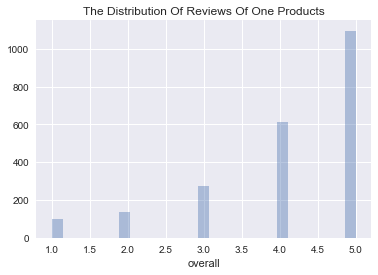

In [190]:
sns.distplot(movies_useful_reviews[movies_useful_reviews.asin=='B003EYVXV4'].overall,kde=False, rug=False)
plt.title('The Distribution Of Reviews Of One Products')

<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Observation Description</b><br>
</font>
<font color='black'>
Among these three categories, the distributions of the reviews for the popular products look similar - most of the reviews gave out 5 stars rates.<br>
    
</font>
</div>

In [191]:
# Distribution of ratings from the users that wrote the largest number of reviews

# for home and kitchen products
home_useful_reviews_num = home_useful_reviews.groupby('reviewerID').count().sort_values(by='asin',ascending = False)
home_useful_reviews_num.head(5)

,asin,helpful,overall,unixReviewTime,reviewTime
reviewerID,,,,,
A1IU7S4HCK1XK0,277,277,277,277,277
A25C2M3QF9G7OQ,227,227,227,227,227
A2ZY49IDE6TY5I,216,216,216,216,216
A2NYK9KWFMJV4Y,184,184,184,184,184
A1W415JP5WEAJK,177,177,177,177,177


Text(0.5,1,'The Distribution Of Reviews Of One Reviewer')

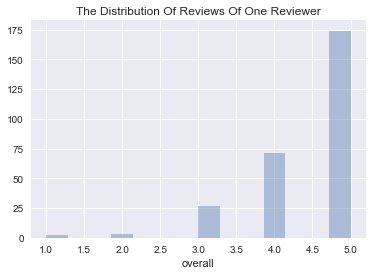

In [194]:
sns.distplot(home_useful_reviews[home_useful_reviews.reviewerID=='A1IU7S4HCK1XK0'].overall,kde=False, rug=False)
plt.title('The Distribution Of Reviews Of One Reviewer')

In [193]:
# for clothing products
clothing_useful_reviews_num = clothing_useful_reviews.groupby('reviewerID').count().sort_values(by='asin',ascending = False)
clothing_useful_reviews_num.head(5)

,asin,helpful,overall,unixReviewTime,reviewTime
reviewerID,,,,,
A2J4XMWKR8PPD0,136,136,136,136,136
A2GA55P7WGHJCP,76,76,76,76,76
A2KBV88FL48CFS,69,69,69,69,69
AENH50GW3OKDA,68,68,68,68,68
A2V5R832QCSOMX,62,62,62,62,62


Text(0.5,1,'The Distribution Of Reviews Of One Reviewer')

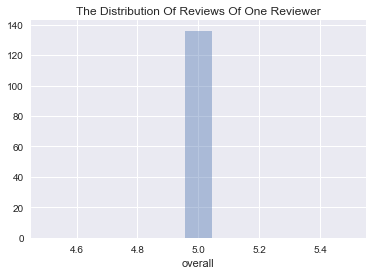

In [195]:
sns.distplot(clothing_useful_reviews[clothing_useful_reviews.reviewerID=='A2J4XMWKR8PPD0'].overall,kde=False, rug=False)
plt.title('The Distribution Of Reviews Of One Reviewer')

In [197]:
# for movies products
movies_useful_reviews_num = movies_useful_reviews.groupby('reviewerID').count().sort_values(by='asin',ascending = False)
movies_useful_reviews_num.head(5)

,asin,helpful,overall,unixReviewTime,reviewTime
reviewerID,,,,,
A3LZGLA88K0LA0,2368,2368,2368,2368,2368
A16CZRQL23NOIW,2333,2333,2333,2333,2333
ANCOMAI0I7LVG,2322,2322,2322,2322,2322
ABO2ZI2Y5DQ9T,2301,2301,2301,2301,2301
A328S9RN3U5M68,2267,2267,2267,2267,2267


Text(0.5,1,'The Distribution Of Reviews Of One Reviewer')

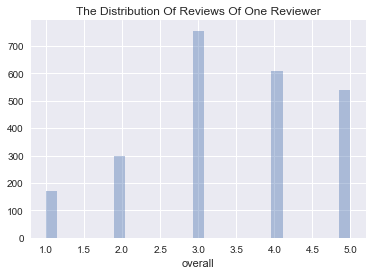

In [198]:
sns.distplot(movies_useful_reviews[movies_useful_reviews.reviewerID=='A3LZGLA88K0LA0'].overall,kde=False, rug=False)
plt.title('The Distribution Of Reviews Of One Reviewer')

<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Observation Description</b><br>
</font>
<font color='black'>
Among these three categories, the distributions of the reviews from various users vary a lot from person to person.<br>
    
</font>
</div>

### Data Enrichment : Based on the rating distribution, we used our human-crafted rules to identify suspicious reviewers and reviews

#### We set a significancel level for the distribution of reviews for each product. Based on the significance level, we calculate the range of the confidence interval. We then see whether each review is within the interval.

In [150]:
# define a function to compute the confidence interval of the rating distribution
def confidence_interval(ratings, level):
    lower_q = (1-level)/2
    return ratings.groupby('asin').apply(lambda x: [x.overall.quantile(lower_q),x.overall.quantile(1-lower_q)])

In [162]:
# define a function to initially label the suspicious reviewers
def inspect_review(df, level):
    df_ci = confidence_interval(df, level)
    df_ci = pd.DataFrame(df_ci).reset_index()
    df_ci.columns = ['asin','ci']
    df_ci = df.merge(df_ci, left_on='asin', right_on='asin')
    
    # the reviews whose rate is out of the confidence interval were regarded as suspicious and labeled 1, otherwise labeled 0
    df_ci['label'] = df_ci.apply(lambda x: 0 if x.overall>=x.ci[0] and x.overall<=x.ci[1] else 1, axis=1)
    
    return df_ci

In [154]:
# for movies and TV products
home_useful_reivews_label = inspect_review(home_useful_reviews, 0.8)
home_useful_reivews_label.head()

,reviewerID,asin,helpful,overall,unixReviewTime,reviewTime,ci,label
0,APYOBQE6M18AA,0615391206,"[0, 0]",5.0,1382140800,"10 19, 2013","[3.9999999999999996, 5.0]",0
1,A1JVQTAGHYOL7F,0615391206,"[0, 0]",5.0,1403049600,"06 18, 2014","[3.9999999999999996, 5.0]",0
2,A3UPYGJKZ0XTU4,0615391206,"[26, 27]",4.0,1367712000,"05 5, 2013","[3.9999999999999996, 5.0]",0
3,A2MHCTX43MIMDZ,0615391206,"[14, 18]",5.0,1312416000,"08 4, 2011","[3.9999999999999996, 5.0]",0
4,AHAI85T5C2DH3,0615391206,"[0, 0]",4.0,1402099200,"06 7, 2014","[3.9999999999999996, 5.0]",0


In [165]:
# for home and kitchen products
print('The Number Of Suspicious Reviewers And Reviews:',sum(home_useful_reivews_label['label']))

The Number Of Suspicious Reviewers And Reviews: 41459


In [157]:
# for clothing products
clothing_useful_reivews_label = inspect_review(clothing_useful_reviews, 0.8)
clothing_useful_reivews_label.head()

,reviewerID,asin,helpful,overall,unixReviewTime,reviewTime,ci,label
0,A1KLRMWW2FWPL4,0000031887,"[0, 0]",5.0,1297468800,"02 12, 2011","[4.0, 5.0]",0
1,A2G5TCU2WDFZ65,0000031887,"[0, 0]",5.0,1358553600,"01 19, 2013","[4.0, 5.0]",0
2,A1RLQXYNCMWRWN,0000031887,"[0, 0]",5.0,1357257600,"01 4, 2013","[4.0, 5.0]",0
3,A8U3FAMSJVHS5,0000031887,"[0, 0]",5.0,1398556800,"04 27, 2014","[4.0, 5.0]",0
4,A3GEOILWLK86XM,0000031887,"[0, 0]",5.0,1394841600,"03 15, 2014","[4.0, 5.0]",0


In [164]:
# for clothing products
print('The Number Of Suspicious Reviewers And Reviews:',sum(clothing_useful_reivews_label['label']))

The Number Of Suspicious Reviewers And Reviews: 23948


In [160]:
# for movies and TV products
movies_useful_reivews_label = inspect_review(movies_useful_reviews, 0.8)
movies_useful_reivews_label.head()

,reviewerID,asin,helpful,overall,unixReviewTime,reviewTime,ci,label
0,ADZPIG9QOCDG5,0005019281,"[0, 0]",4.0,1203984000,"02 26, 2008","[3.0, 5.0]",0
1,A35947ZP82G7JH,0005019281,"[0, 0]",3.0,1388361600,"12 30, 2013","[3.0, 5.0]",0
2,A3UORV8A9D5L2E,0005019281,"[0, 0]",3.0,1388361600,"12 30, 2013","[3.0, 5.0]",0
3,A1VKW06X1O2X7V,0005019281,"[0, 0]",5.0,1202860800,"02 13, 2008","[3.0, 5.0]",0
4,A3R27T4HADWFFJ,0005019281,"[0, 0]",4.0,1387670400,"12 22, 2013","[3.0, 5.0]",0


In [163]:
# for movies products
print('The Number Of Suspicious Reviewers and Reviews:',sum(movies_useful_reivews_label['label']))

The Number Of Suspicious Reviewers and Reviews: 111731
